# QML Project

```
AUTHORS
Charlie BROSSE  
Guillaume CARRIERE  
Marius DUBOSC
```

invisibleL'objectif du projet et de reproduire les circuits et les résultats obtenus dans le papier "Polyadic Quantum Classifier" (https://arxiv.org/abs/2007.14044)

In [226]:
!pip3 install qiskit --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [227]:
import qiskit
from scipy.special import erfinv
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split

qs = qiskit.Aer.get_backend('qasm_simulator')

# Useful functions

## Preprocessing functions

In [228]:
def standardise(x):
    return (x - np.mean(x)) / np.std(x)

def rescaleFeature(x, alpha, q):
    return (1-alpha/2) * (np.pi/q) * standardise(x)

## Circuit functions

In [229]:
def psiGate(qc, param, bit):
    qc.rx(np.pi/2, bit)
    qc.rz(param, bit)
    qc.rx(np.pi/2, bit)

# Quantum Classifier Class

In [230]:
def logSoftmax(label, job_results, bitstrings, nshots) :
    if label in job_results :
        e = np.exp(job_results[label] / nshots)
    else :
        e = 1
        
    s = 0
    for bitstring in bitstrings :
        if bitstring in job_results :
            s += np.exp(job_results[bitstring] / nshots)
        else :
            s += 1 
            
    return -np.log(e / s)


In [231]:
class QuantumClassifier:

    def __init__(self, circuit_builder, bitstrings, theta_size, loss_function = logSoftmax, optimizer_method = "COBYLA"):
        self.circuit_builder = circuit_builder
        self.bitstrings = bitstrings
        self.theta_size = theta_size
        self.loss_function = loss_function
        self.optimizer_method = optimizer_method
        self.theta = None
        self.nshots = 100
        
    
    # Training functions
    def executeJob(self, circuit):
        job = qiskit.execute(circuit, shots=self.nshots, backend=qs)
        job_results = job.result().get_counts()
        return job_results

    def runCircuit(self, theta, X, y):
        omega = X
        label = y

        circuit = self.circuit_builder(theta, omega)
        job_results = self.executeJob(circuit)
        return self.loss_function(label, job_results, self.bitstrings, self.nshots)
        
        
    def lossBatch(self, theta, X, y):
    
        total_loss = 0

        batch = list(zip(X, y))

        for X_el, y_el in zip(X, y) :
            total_loss += self.runCircuit(theta, X_el, y_el)

        total_loss /= len(y)
        
        print("loss: " + str(total_loss))
        
        return total_loss

        
    def fit(self, X, y, nshots=100, maxiter=20, theta=None):
        
        if theta is not None:
            self.theta = theta
            
        if self.theta is None:
            self.theta = np.random.uniform(0, 2 * np.pi, self.theta_size)
            
        self.nshots = nshots

        opt = sp.optimize.minimize(
            fun=lambda params : self.lossBatch(params, X, y),
            x0=self.theta,
            method=self.optimizer_method,
            options={'maxiter': maxiter}
        )
        
        self.theta = opt.x
        
        return opt
    
    # Testing functions
    def argmaxJobResults(self, job_results):
        max_label_value = None
        max_label = None
    
        for label in job_results :
            if label in self.bitstrings and (max_label_value is None or job_results[label] >= max_label_value) :
                max_label = label
                max_label_value = job_results[label]
        return max_label
    
    def predict(self, X, theta=None, nshots=100):
        
        if theta is not None:
            self.theta = theta
            
        self.nshots = nshots
        
        y_pred = []
        
        for omega in X :    
            circuit = self.circuit_builder(self.theta, omega)
            job_results = self.executeJob(circuit)
            y_pred.append(self.argmaxJobResults(job_results))

        return y_pred

    def compute_accuracy(self, y_pred, y) :
        correct = 0

        for y_pred_el, y_el in zip(y_pred, y) :
            if y_pred_el == y_el :
                correct += 1
        
        return correct / len(y)

# IRIS

## Construct dataset

### Import dataset

In [232]:
df = pd.read_csv("iris.data")
df

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


### Preprocess

In [233]:
alpha = 0.1
q = 3

#q = 3 fixé dans le papier

attributes = df.columns[:-1]

for x in attributes:
    df[x] = rescaleFeature(df[x], alpha, q)

df

,sepal-length,sepal-width,petal-length,petal-width,class
0,-0.896032,1.026729,-1.334348,-1.306199,Iris-setosa
1,-1.137116,-0.124313,-1.334348,-1.306199,Iris-setosa
2,-1.378201,0.336104,-1.390920,-1.306199,Iris-setosa
3,-1.498743,0.105896,-1.277776,-1.306199,Iris-setosa
4,-1.016574,1.256938,-1.334348,-1.306199,Iris-setosa
...,...,...,...,...,...
145,1.032646,-0.124313,0.815393,1.440481,Iris-virginica
146,0.550477,-1.275354,0.702249,0.917304,Iris-virginica
147,0.791562,-0.124313,0.815393,1.048098,Iris-virginica
148,0.429934,0.796521,0.928537,1.440481,Iris-virginica


In [234]:
diconvert = {
    "Iris-setosa" : "00",
    "Iris-versicolor" : "01",
    "Iris-virginica" : "10"
}

df = df.replace({"class": diconvert})
df

,sepal-length,sepal-width,petal-length,petal-width,class
0,-0.896032,1.026729,-1.334348,-1.306199,00
1,-1.137116,-0.124313,-1.334348,-1.306199,00
2,-1.378201,0.336104,-1.390920,-1.306199,00
3,-1.498743,0.105896,-1.277776,-1.306199,00
4,-1.016574,1.256938,-1.334348,-1.306199,00
...,...,...,...,...,...
145,1.032646,-0.124313,0.815393,1.440481,10
146,0.550477,-1.275354,0.702249,0.917304,10
147,0.791562,-0.124313,0.815393,1.048098,10
148,0.429934,0.796521,0.928537,1.440481,10


In [235]:
X = df[attributes].values
y = df["class"].values

### Split

In [236]:
train_size = 90
test_size = 60

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, train_size=train_size, stratify=y)

## Circuit

In [237]:
def irisCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2, 2)
    
    iris_circuit = qiskit.QuantumCircuit(2)
    for i in range(4):
        if i : iris_circuit.cz(0, 1)
        psiGate(iris_circuit, omega[(2*i) % 4], 0)
        psiGate(iris_circuit, omega[(2*i+1) % 4], 1)
        
        iris_circuit.cz(0, 1)
        
        psiGate(iris_circuit, theta[(2*i)], 0)
        psiGate(iris_circuit, theta[(2*i+1)], 1)
        
    qc.append(iris_circuit, range(2))
    qc.measure(range(2), range(2))
    
    return qc

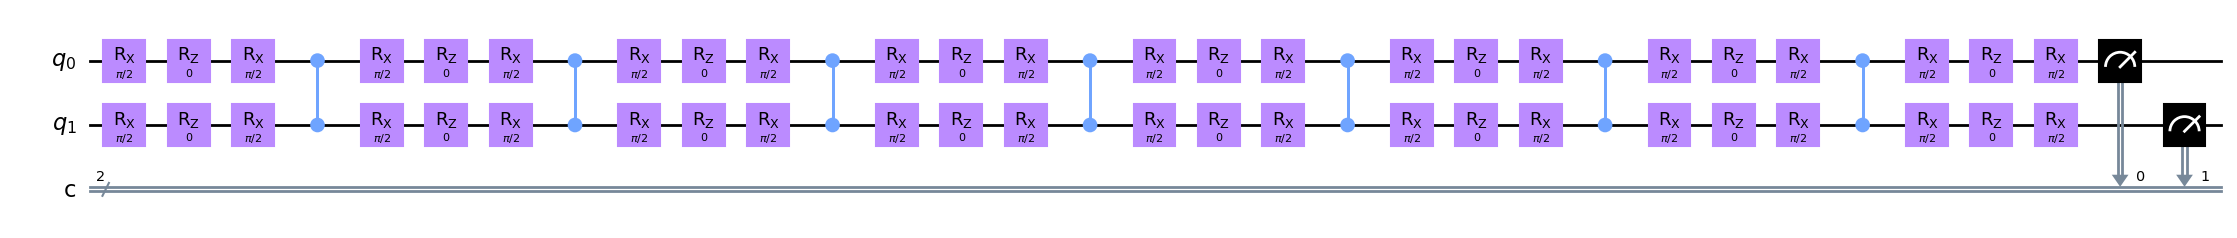

In [238]:
irisCircuit(np.zeros(8), np.zeros(4)).decompose().draw("mpl", fold=40)

## Train

In [239]:
iris_classifier = QuantumClassifier(irisCircuit, ['00', '01', '10'], 8)

In [240]:
opt = iris_classifier.fit(X_train, y_train, nshots=250, maxiter=20)

loss: 1.1669126656913802
loss: 1.1133952808337106
loss: 1.1361752829848457
loss: 1.0964493331396872
loss: 1.0846504555637404
loss: 1.069530850147901
loss: 1.1114340540965268
loss: 1.0997272056517944
loss: 1.112152709075683
loss: 1.0992870402961246
loss: 1.0648450215950191
loss: 1.0808955605486499
loss: 1.0746095507109872
loss: 1.0858447831534064
loss: 1.0526437980974217
loss: 1.0331980077890337
loss: 1.0267183325637796
loss: 1.0230148139130872
loss: 1.0360104503754601
loss: 1.0247290929322912


In [241]:
opt = iris_classifier.fit(X_train, y_train, nshots=500, maxiter=30)

loss: 1.0247125227003666
loss: 1.0811536520191696
loss: 1.046395804776049
loss: 1.003841793406955
loss: 1.029779913977585
loss: 0.981762467977035
loss: 1.0368702732214352
loss: 1.084623489387093
loss: 1.1109391619596714
loss: 0.9528650382993441
loss: 1.054157800035725
loss: 0.9766988880536243
loss: 0.9963300933116126
loss: 0.9744644266458065
loss: 0.9405918452382166
loss: 0.951019738508142
loss: 0.9267559979892538
loss: 0.9320414427436049
loss: 0.923669869268968
loss: 0.9166716453119791
loss: 0.9580231870627677
loss: 0.9157531307435529
loss: 0.9138312480478212
loss: 0.9153877757098723
loss: 0.9128143074279764
loss: 0.9117130847942609
loss: 0.917299830393142
loss: 0.9116220145263646
loss: 0.9255481739226167
loss: 0.9080069838467989


In [242]:
opt = iris_classifier.fit(X_train, y_train, nshots=750, maxiter=70)

loss: 0.9040921310557912
loss: 1.0124784579609238
loss: 0.996077342645491
loss: 0.9846354156818906
loss: 0.975979554937655
loss: 0.9603329115094449
loss: 0.9823173230286718
loss: 1.011297831075856
loss: 0.9798898165682947
loss: 0.8716378696631145
loss: 0.9758920264725268
loss: 0.900390509505879
loss: 0.9323859245163558
loss: 0.8862894598432907
loss: 0.8739964110529976
loss: 0.9066305760975584
loss: 0.9012264674379755
loss: 0.8550140918160821
loss: 0.8848020335314533
loss: 0.8788322249988124
loss: 0.8464289176594701
loss: 0.844855840320046
loss: 0.8659275332024808
loss: 0.8389610714655463
loss: 0.7940879067877246
loss: 0.8140074989366402
loss: 0.8130777979945658
loss: 0.8127168797998986
loss: 0.7894084847200185
loss: 0.791743395861162
loss: 0.7883371250419068
loss: 0.7833984511702
loss: 0.7938362204448192
loss: 0.7933406421390438
loss: 0.7724668985249533
loss: 0.7636355232036517
loss: 0.7651298211944907
loss: 0.7688906298890534
loss: 0.7781882618774846
loss: 0.7610888484085356
loss: 0.7

## Compute results

In [243]:
y_pred = iris_classifier.predict(X_train)
iris_classifier.compute_accuracy(y_pred, y_train)

0.9111111111111111

In [244]:
y_pred = iris_classifier.predict(X_test)
iris_classifier.compute_accuracy(y_pred, y_test)

0.8666666666666667

# Gaussian XOR

## Construct dataset

### Generate dataset

In [299]:
import numpy as np
import math

In [300]:
def generate_gaussian_point(x, y) :
    pick_x = np.random.normal(loc=x, scale = 0.5)
    pick_y = np.random.normal(loc=y, scale = 0.5)
    return [pick_x, pick_y]

In [301]:
#dans le papier ils utilisent 1.5 et non pi / 2, a tester...

center1 = (-np.pi / 2, 0)
center2 = (np.pi / 2, 0)
center3 = (0, -np.pi / 2)
center4 = (0, np.pi / 2)

centers = [center1, center2, center3, center4]


In [302]:
X_train = []
y_train = []

for i in range(20) :
    X_train.append(generate_gaussian_point(*center1))
    y_train.append(0)
    
    X_train.append(generate_gaussian_point(*center2))
    y_train.append(0)
    
    X_train.append(generate_gaussian_point(*center3))
    y_train.append(1)
    
    X_train.append(generate_gaussian_point(*center4))
    y_train.append(1)
    
X_train = np.array(X_train)
y_train = np.array(y_train)

In [303]:
lin = np.linspace(-np.pi, np.pi, num = 50)
X_test = np.array([[x, y] for x in lin for y in lin])

y_test = [1 if abs(el[0]) < abs(el[1]) else 0 for el in X_test]

(-3.141592653589793, 3.141592653589793)

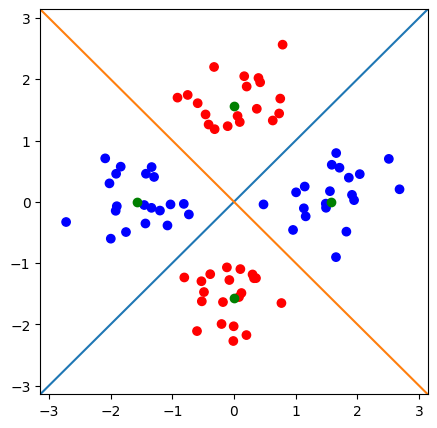

In [304]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [5,5]

c = ["blue" if el==0 else "red" for el in y_train]

plt.scatter(X_train[:, 0], X_train[:, 1], color=c)

x,y = zip(*centers)
plt.scatter(x, y, color='green')



x = np.linspace(-np.pi, np.pi, 100)
y = x
y2 = - x

plt.plot(x,y)
plt.plot(x,y2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

### Preprocess

In [305]:
diconvert = {
    0 : "00",
    1 : "10",
}

new_y_train = [diconvert[x] for x in y_train]
new_y_test = [diconvert[x] for x in y_test]

y_train = new_y_train
y_test = new_y_test

y_train[:10]

['00', '00', '10', '10', '00', '00', '10', '10', '00', '00']

## Circuit

In [306]:
def xorCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2, 2)
    
    xor_circuit = qiskit.QuantumCircuit(2)
    
    psiGate(xor_circuit, omega[0], 0)
    psiGate(xor_circuit, omega[1], 1)
    
    for i in range(2):
        xor_circuit.cz(0, 1)
        psiGate(xor_circuit, theta[2*i], 0)
        psiGate(xor_circuit, theta[2*i+1], 1)
        
    
    qc.append(xor_circuit, range(2))
    qc.measure(range(2), range(2))
    return qc

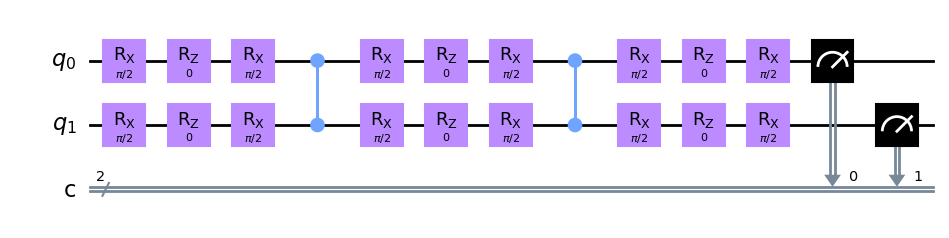

In [307]:
xorCircuit(np.zeros(8), np.zeros(4)).decompose().draw("mpl", fold=40)

## Train

In [308]:
xor_classifier = QuantumClassifier(xorCircuit, ['00', '10'], 4)

In [309]:
xor_opt = xor_classifier.fit(X_train, y_train, nshots=250, maxiter=80)
xor_opt

loss: 0.8131509379496025
loss: 0.8892204966882591
loss: 0.7097682462678473
loss: 0.6537833862085284
loss: 0.7402802448859329
loss: 0.5937778415021291
loss: 0.648290562970335
loss: 0.6046673410423591
loss: 0.5943283603438072
loss: 0.599124170226472
loss: 0.5925126511016047
loss: 0.5925209570159826
loss: 0.5978874805605312
loss: 0.5935529748295348
loss: 0.5861475495809898
loss: 0.5748318505583325
loss: 0.5772844617820188
loss: 0.5767230240103806
loss: 0.5696447765473365
loss: 0.5563051707440391
loss: 0.5518937568219829
loss: 0.5493575761147221
loss: 0.5475149751021638
loss: 0.5578037715611063
loss: 0.558237136914294
loss: 0.5326676043368723
loss: 0.5190138709056981
loss: 0.5095987989614359
loss: 0.5018612543675485
loss: 0.509904374880509
loss: 0.5084761704174522
loss: 0.49347659199046595
loss: 0.49500676322281106
loss: 0.49428731170193546
loss: 0.4938560345195199
loss: 0.48954997199556816
loss: 0.49621083941132993
loss: 0.49295901837478306
loss: 0.4934084205230563
loss: 0.493721842582011

     fun: 0.49246152871665033
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 67
  status: 1
 success: True
       x: array([1.63645721, 6.28125485, 1.62789707, 3.06187493])

## Compute results

In [310]:
y_pred = xor_classifier.predict(X_train)
xor_classifier.compute_accuracy(y_pred, y_train)

1.0

In [311]:
y_pred = xor_classifier.predict(X_test)

(-3.141592653589793, 3.141592653589793)

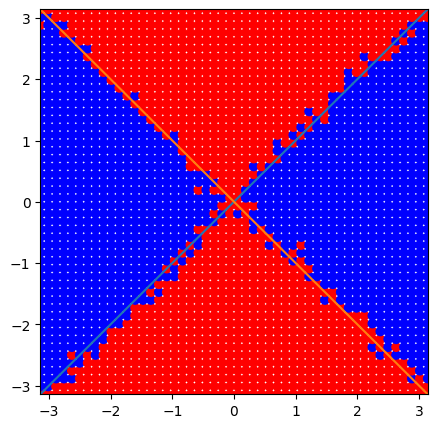

In [312]:
plt.rcParams['figure.figsize'] = [5,5]


c = ["blue" if el=="00" else "red" for el in y_pred]
plt.scatter(X_test[:, 0], X_test[:, 1], color=c)

x = np.linspace(-np.pi, np.pi, 100)
y = x
y2 = - x

plt.plot(x,y)
plt.plot(x,y2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])

In [313]:
xor_classifier.compute_accuracy(y_pred, y_test)

0.9512

## Compare with GaussianNB

In [753]:
from sklearn.naive_bayes import GaussianNB

In [754]:
gaussianNb = GaussianNB()

X_train = dataset[:, :2]
y_train = dataset[:,2]

gaussianNb.fit(X_train, y_train)

y_test = [1 if abs(el[0]) < abs(el[1]) else 0 for el in X_test]

score = gaussianNb.score(X_test, y_test)

In [755]:
score

0.916

# Skin segmentation

## Construct dataset

### Import dataset

In [315]:
df = pd.read_csv("Skin_NonSkin.txt", sep='\t', header=None)
df

,0,1,2,3
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1
...,...,...,...,...
245052,163,162,112,2
245053,163,162,112,2
245054,163,162,112,2
245055,163,162,112,2


### Preprocess

In [316]:
alpha = 0.1
q = 3

attributes = df.columns[:-1]

for x in attributes:
    df[x] = rescaleFeature(df[x], alpha, q)

df

,0,1,2,3
0,-0.816021,-0.788476,-0.002429,1
1,-0.832001,-0.805073,-0.016139,1
2,-0.847981,-0.821670,-0.029849,1
3,-0.879941,-0.854863,-0.057269,1
4,-0.879941,-0.854863,-0.057269,1
...,...,...,...,...
245052,0.606191,0.489488,-0.153241,2
245053,0.606191,0.489488,-0.153241,2
245054,0.606191,0.489488,-0.153241,2
245055,0.606191,0.489488,-0.153241,2


In [317]:
diconvert = {
    1 : "000",
    2 : "111"
}

df = df.replace({3: diconvert})
df

,0,1,2,3
0,-0.816021,-0.788476,-0.002429,000
1,-0.832001,-0.805073,-0.016139,000
2,-0.847981,-0.821670,-0.029849,000
3,-0.879941,-0.854863,-0.057269,000
4,-0.879941,-0.854863,-0.057269,000
...,...,...,...,...
245052,0.606191,0.489488,-0.153241,111
245053,0.606191,0.489488,-0.153241,111
245054,0.606191,0.489488,-0.153241,111
245055,0.606191,0.489488,-0.153241,111


In [318]:
X = df[attributes].values
y = df[3].values

### Split

In [319]:
train_size = 600
test_size = 400

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, train_size=train_size, stratify=y)

## Circuit

In [321]:
def skinSegCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(3, 3)
    
    skin_seg_circuit = qiskit.QuantumCircuit(3)
    psiGate(skin_seg_circuit, omega[0], 0)
    psiGate(skin_seg_circuit, omega[1], 1)
    psiGate(skin_seg_circuit, omega[2], 2)
    
    skin_seg_circuit.cz(0, 2)
    
    psiGate(skin_seg_circuit, theta[0], 0)
    psiGate(skin_seg_circuit, theta[1], 2)
    
    skin_seg_circuit.cz(0, 1)
    
    psiGate(skin_seg_circuit, theta[2], 0)
    psiGate(skin_seg_circuit, theta[3], 1)
    
    skin_seg_circuit.cz(1, 2)
    
    psiGate(skin_seg_circuit, theta[4], 1)
    psiGate(skin_seg_circuit, theta[5], 2)
    
    qc.append(skin_seg_circuit, range(3))
    qc.measure(range(3), range(3))
    
    return qc

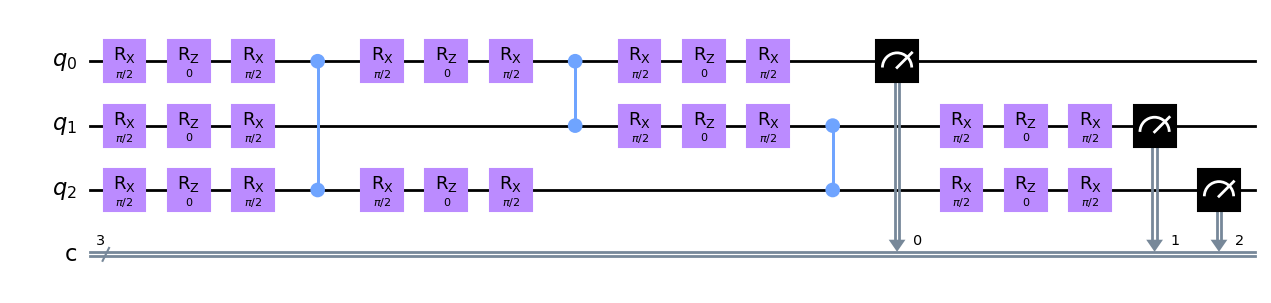

In [322]:
skinSegCircuit(np.zeros(6), np.zeros(3)).decompose().draw("mpl", fold=40)

## Train

In [333]:
skin_classifier = QuantumClassifier(skinSegCircuit, ['000', '111'], 6, optimizer_method = "COBYLA")

In [334]:
opt = skin_classifier.fit(X_train, y_train, nshots=250, maxiter=60)
opt

loss: 0.6650483604996839
loss: 0.6675175016831364
loss: 0.6972538585680467
loss: 0.6791740504448985
loss: 0.6547804879521013
loss: 0.6564633350450325
loss: 0.5993471070742034
loss: 0.6042808657959565
loss: 0.6026699583597022
loss: 0.6119096691993093
loss: 0.5894564324868558
loss: 0.5978884413634947
loss: 0.6071162983651737
loss: 0.6029805041923589
loss: 0.576176569358152
loss: 0.5731879088552685
loss: 0.5831723073067888
loss: 0.5838886923037673
loss: 0.5678345711394414
loss: 0.5559171922727886
loss: 0.5544914548294805
loss: 0.5606880887987754
loss: 0.5604646286762086
loss: 0.552652594456309
loss: 0.5539360191011823
loss: 0.5563808936929407
loss: 0.5517161329129118
loss: 0.5540141901745105
loss: 0.5539332733975073
loss: 0.5511153608440162
loss: 0.5513593014324748
loss: 0.5523598996691819
loss: 0.5529028631245968
loss: 0.5503309950358483
loss: 0.5496003062573585
loss: 0.548488323251386
loss: 0.549551733214751
loss: 0.549455485717304
loss: 0.5492568753893904
loss: 0.5489229631131685
loss:

     fun: 0.5469826165614535
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 60
  status: 2
 success: False
       x: array([5.78218354, 1.83243978, 5.93577892, 6.82300215, 6.88906438,
       7.54226803])

## Compute results

In [335]:
y_pred = skin_classifier.predict(X_train)
skin_classifier.compute_accuracy(y_pred, y_train)

0.71

In [336]:
y_pred = skin_classifier.predict(X_test)
skin_classifier.compute_accuracy(y_pred, y_test)

0.71

# Synthetic dataset with 4 classes

## Construct dataset

### Generate dataset

In [352]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=5000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, n_classes=4)

### Preprocess

In [354]:
alpha = 0.1
q = 3


X[:, 0] = rescaleFeature(X[:, 0], alpha, q)
X[:, 1] = rescaleFeature(X[:, 1], alpha, q)

X[:10]

array([[-1.29214804,  1.40760177],
       [ 1.03234535,  0.80398178],
       [-0.21579835, -0.71224043],
       [ 0.56397006,  0.54379044],
       [-0.85388759, -2.01820387],
       [ 1.10631195,  1.16048008],
       [-0.37165698,  0.57868321],
       [ 1.41948381, -1.19889306],
       [-0.61330491, -0.31278072],
       [-1.2986241 ,  0.047761  ]])

In [360]:
new_y = []

diconvert = {
    0 : "00",
    1 : "01",
    2 : '10',
    3 : '11'
}

for el in y:
    new_y.append(diconvert[el])

y = new_y

y[:10]

['01', '11', '10', '11', '00', '11', '01', '10', '10', '00']

### Split

In [361]:
train_size = 0.6
test_size = 0.4

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, train_size=train_size, stratify=y)

## Circuit

In [364]:
def syntheticCircuit(theta, omega):
    qc = qiskit.QuantumCircuit(2, 2)

    synthetic_circuit = qiskit.QuantumCircuit(2)
    for i in range(2):
        if i : synthetic_circuit.cz(0, 1)
        
        psiGate(synthetic_circuit, omega[0], 0)
        psiGate(synthetic_circuit, omega[1], 1)
        synthetic_circuit.cz(0, 1)
        
        psiGate(synthetic_circuit, theta[(6*i)], 0)
        psiGate(synthetic_circuit, theta[(6*i+1)], 1)
        synthetic_circuit.cz(0, 1)
        
        psiGate(synthetic_circuit, omega[0], 0)
        psiGate(synthetic_circuit, omega[1], 1)
        synthetic_circuit.cz(0, 1)
        
        psiGate(synthetic_circuit, theta[(6*i+2)], 0)
        psiGate(synthetic_circuit, theta[(6*i+3)], 1)
        synthetic_circuit.cz(0, 1)
        
        psiGate(synthetic_circuit, theta[(6*i+4)], 0)
        psiGate(synthetic_circuit, theta[(6*i+5)], 1)
    
    qc.append(synthetic_circuit, range(2))
    qc.measure(range(2), range(2))
    
    return qc

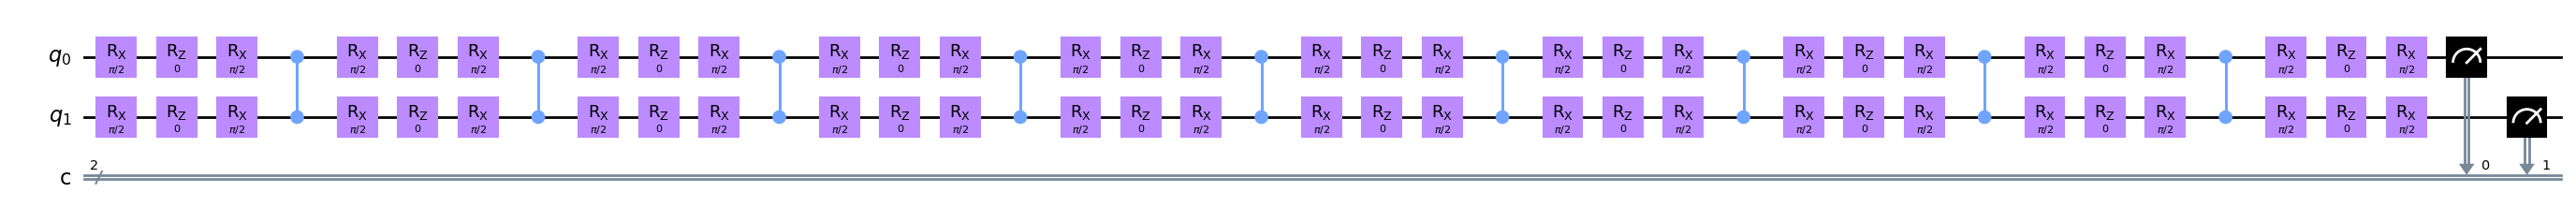

In [366]:
syntheticCircuit(np.zeros(12), np.zeros(2)).decompose().draw("mpl", fold=50)

## Train

In [367]:
synthetic_classifier = QuantumClassifier(syntheticCircuit, ['00', '01', '10', '11'], 12, optimizer_method = "COBYLA")

In [368]:
opt = synthetic_classifier.fit(X_train, y_train, nshots=250, maxiter=60)
opt

loss: 1.4623152141575837
loss: 1.4537853958956
loss: 1.3772279031463952
loss: 1.3687571872023179
loss: 1.4280420995982455
loss: 1.3214823700991758
loss: 1.348019215118249
loss: 1.3570660322932164
loss: 1.2740285895407695
loss: 1.3373436490692039
loss: 1.2712272387917116
loss: 1.3602352843840373
loss: 1.2608350871493033
loss: 1.3076699692348084
loss: 1.2704456192389677
loss: 1.2290482047470002
loss: 1.2384417025343695
loss: 1.371691444156307
loss: 1.2361558700795485
loss: 1.2689345091468867
loss: 1.2489544109242248
loss: 1.241757278730224
loss: 1.2349674360687954
loss: 1.231725941821295
loss: 1.2190762598021525
loss: 1.2343558006671533
loss: 1.2223941310919304
loss: 1.2133748193394074
loss: 1.2364914929218367
loss: 1.2265828963850807
loss: 1.2133622374955346
loss: 1.2162934076635492
loss: 1.2809920305677494
loss: 1.2087998221852594
loss: 1.2100685824915713
loss: 1.1932010416774617
loss: 1.1912325152194103
loss: 1.1965949214197156
loss: 1.1788449990697731
loss: 1.178226534716483
loss: 1.

     fun: 1.1080872824197443
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 60
  status: 2
 success: False
       x: array([4.96029031, 5.14418624, 5.24956794, 4.54360843, 6.98430387,
       0.92068341, 4.1398482 , 5.88286199, 5.15626578, 5.79871654,
       4.40396239, 3.55160734])

## Compute results

In [369]:
y_pred = synthetic_classifier.predict(X_train)
synthetic_classifier.compute_accuracy(y_pred, y_train)

0.6763333333333333

In [370]:
y_pred = synthetic_classifier.predict(X_test)
synthetic_classifier.compute_accuracy(y_pred, y_test)

0.671

# Run on IBM Quantum Computer

In [ ]:
TOKEN = ...

In [ ]:
qiskit.IBMQ.save_account(TOKEN, overwrite=True) 
provider = qiskit.IBMQ.load_account()
backend = qiskit.providers.ibmq.least_busy(provider.backends())

mapped_circuit = qiskit.transpile(circuit, backend=backend)
qobj = qiskit.assemble(mapped_circuit, backend=backend, shots=1024)

IBMQAccountCredentialsInvalidToken: 'Invalid IBM Quantum Experience token found: "Ellipsis" of type <class \'ellipsis\'>.'

In [ ]:
# execute the circuit
job = backend.run(qobj)


In [ ]:
job.status()


In [ ]:
ID = job.job_id()

In [ ]:
job = backend.retrieve_job(ID)

In [ ]:
result = job.result()

In [ ]:
counts = result.get_counts()

In [ ]:
counts